# GANs: Taking care of the resolution effect 

## Introduction

Measurement in Nuclear and Hadron Physics often involve measurement of a complex final state.

Let's look at the following examples:

* $\gamma p \rightarrow \pi^0 p$  Is a two-body final state process. Its cross section can be described as $\frac{d^2\sigma}{d\Omega} = \frac{d^2\sigma(\theta, \phi)}{d\Omega} $.

* $\gamma p \rightarrow \pi^+ \pi^- p$  Is a three-body final state process. Its cross section can be described as $\frac{d^5\sigma}{dM^2_{p\pi^-}dM^2_{\pi^+\pi^-}dt_{\pi^+}d\alpha_{[\pi^+p][\pi-+p']}\phi}  $.

Comparing these two cross-sections, we can observe how the more complex the final state is, the higher is the number of final variables we have to take into account in order to fully describe our process. On top of that, each of these variables is derived from the manipulation of observables obtained through a detector, which leads to the propagation of systematic experimental uncertainties, due to the detector finite resolution. 

When comparing these results with the ones derived from theory, we'd like to have an error band, on the determination of the experimental cross-section, as small as possible, in order to constrain the free parameters of the theory as tightly as possible.


AI, and especially GANs comes in handy to take care of this task in a comprehensive manner!

## GANs

Generative Adversarial Networks (GANs for short) are a type of generative model based on the competition of two models, which are trained in an alternate fashon for each training epoch:

* The **Generator** task is to convert some input, such as noise, into an output which is as close as possible

* The **Discriminator** is a binary classifier whose task is to distinguish if the events which it's fed with are coming from the training set or are the output of the Generator.

The output of the Discriminator will enter the loss function and will contribute to the backpropagation algorithm and the consequent update of the whole network weights.

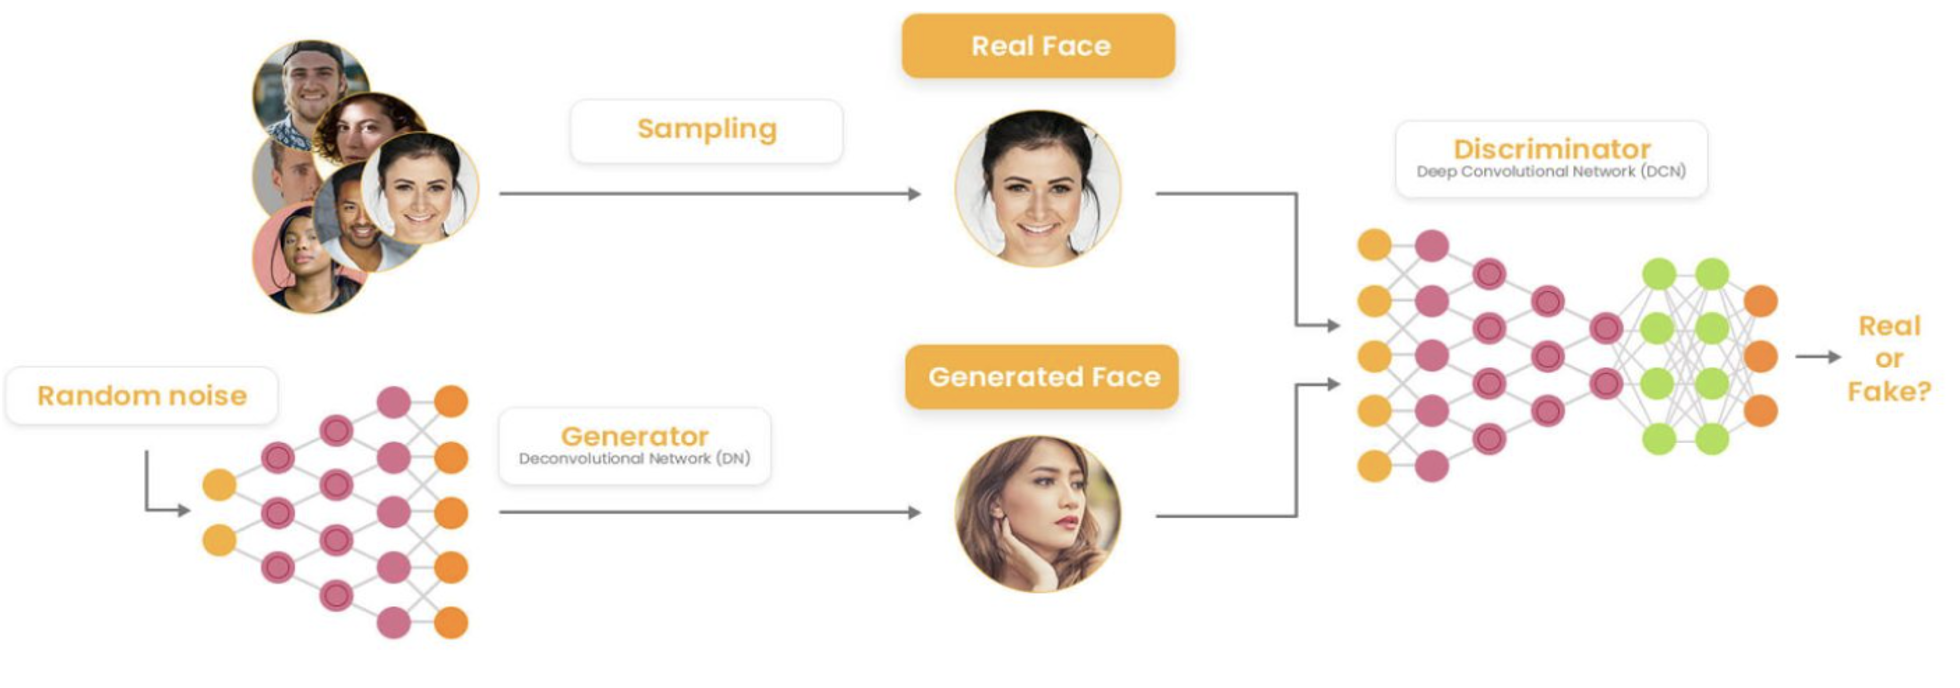


These models fit particularly well our type of problem. In fact, these models are able to:

* Recover complex distributions with great accuracy
* Perform its task in an un-binned or event-level way

We are then able to train a GAN on a particular detector setup, using simulation, in order to mimic the detector's distortion effects and to recover the vertex level (physics) distributions, free of any detector smearing.

The goal of this exercise is to create, in a simplified situation, a detector proxy which will mimic a simplified version of the smearing applied from a real detector.

# Setup definition

## Variables definition:

In our case we will be dealing with events $\Rightarrow$ particles final states $\Rightarrow$ particles 4-momenta.

Our events will be then look like this: $P_{part}^{\mu} = (E_{part}, P_{z_{part}}, P_{z_{part}}, P_{z_{part}})$ and we will have to distinguish between two type of events:

* **Vertex-level** events are the ones obtained directly from the physics distribution and know nothing about the detector and are referred as "V_data".

* **Detector-level** events are V_data after being processed by the detector proxy. These events will contain all the characteristic distortions coming from the detector.

## Our version of the GAN:

In this notebook we will be looking at one of the many variations of the traditional GAN, developed ad hoc to increase its stability and guarantee a faster convergence. The main differences we can observe are:

1. We are using a **Conditional GAN** (cGAN). This means that the generator input is not only noise, but the noise is concatenated with events from vertex-level distribution, which is an essential step in our workflow. In fact, since we are interested in correlating a given vertex-level input, to a given detector-level output, it is natural to include the vertex-level data as part of the input of the generator.

2. We are applying the trick of concatenating the vertex-level events to the output of the generator. This has no deep theoretical meaning, but has been shown to significantly improve the model's convergence.

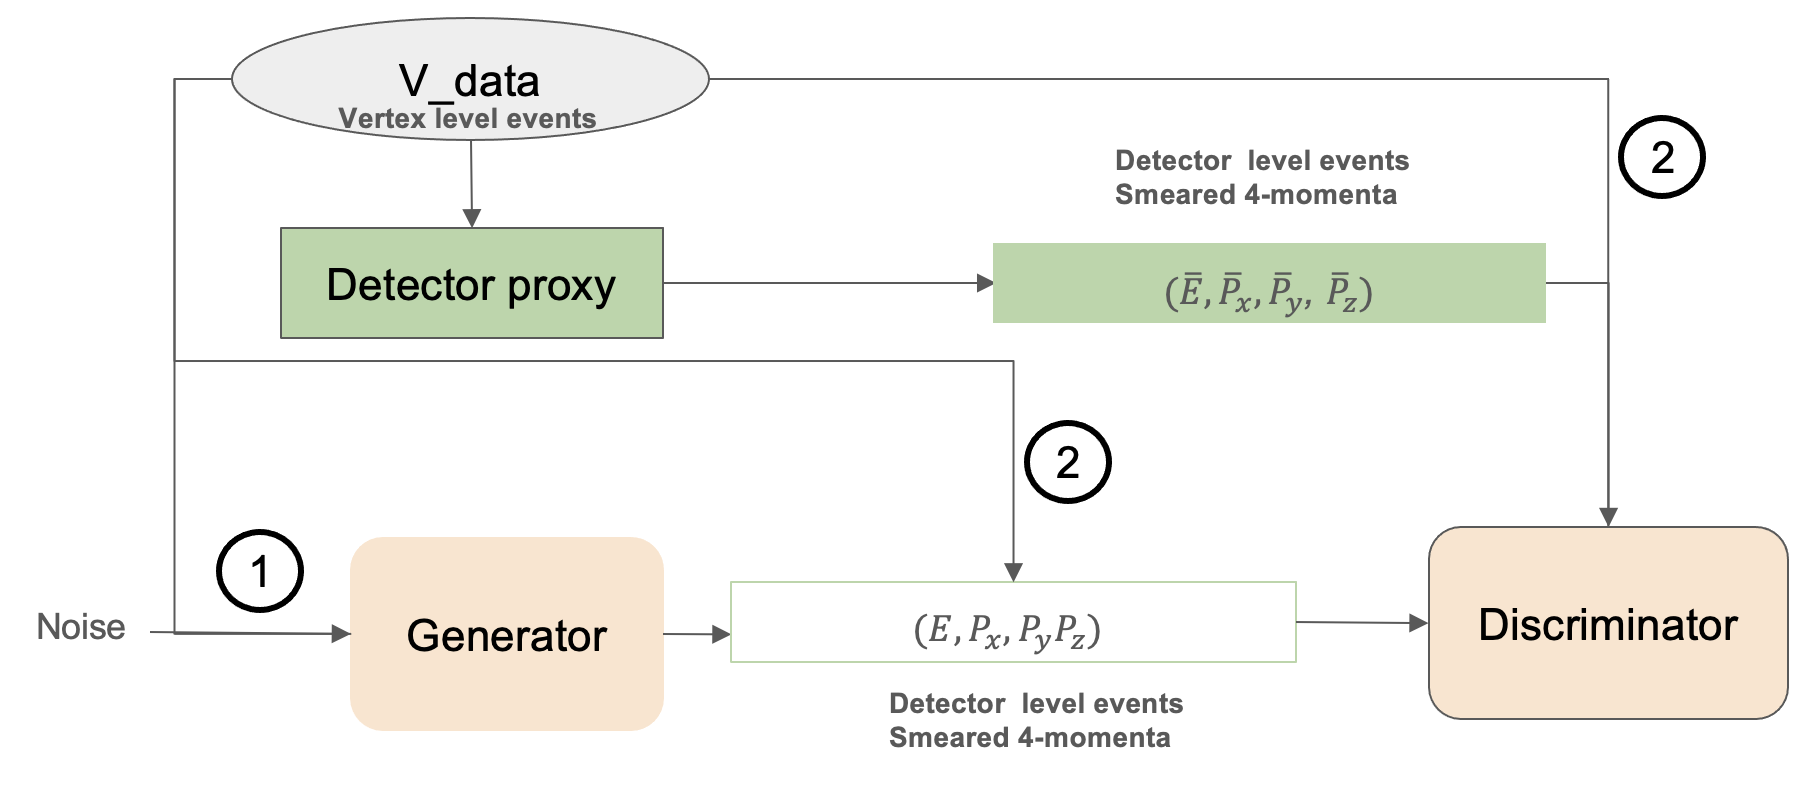

## Loss function:


### Discriminator Loss $L_D$:

As mentioned, any GAN training is composed of an adversarial training between the generator and the discriminator. Hence, we will have to deal with two different loss functions. Since the output of the discriminator depends on the output of the Generator, we can write its loss function as:
$$
L_D = \frac{1}{2} \mathbb{E}_{x \sim p_{\text{data}}} \left[ \left( D(x) - 1 \right)^2 \right] + \frac{1}{2} \mathbb{E}_{z \sim p_l} \left[ \left( D(G(z)) \right)^2 \right]
$$

Where:
- $D(x)$: Discriminator's output for real samples $x$.
- $D(G(z))$: Discriminator's output for generated samples $G(z)$.
- $E_{x \sim p_{data}}$: Expectation over the real data distribution.
- $E_{z \sim p_l}$: Expectation over the latent space distribution $p_l$.

---

### Generator Loss $L_G$:


$$L_G = \frac{1}{2} \mathbb{E}_{z \sim p_l} \left[ \left( D(G(z)) - 1 \right)^2 \right]$$


Where:
- $D(G(z))$: Discriminator's output for generated samples $G(z)$.
- $E_{z \sim p_l}$: Expectation over the latent space distribution $p_l$.

### Explanation:
1. **Discriminator Loss**:
   - The discriminator minimizes $(D(x) - 1)^2$ for real samples to output $1$ for real data.
   - It minimizes $(D(G(z)))^2$ for fake samples to output $0$ for fake data.

2. **Generator Loss**:
   - The generator minimizes $(D(G(z)) - 1)^2$ to generate samples that the discriminator classifies as real.

## HANDS ON 0: Loss function estimation

Given these definitions of the loss function $L_G$ and $L_D$:

* When can we say that our model is trained?  

* What values should $L_D$ and $L_G$ have?

### HANDS ON 0: Answer

In these cases we can say that our model converged once we achieved a **dynamical** equilibrium between the two models: Here, we expect the $L_G \rightarrow 0.25$ while $L_D \rightarrow 0.125$

### HANDS ON 1: Training-Data visualization and preprocessing

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, concatenate
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import LogNorm
import pylab as pyy

import matplotlib.pyplot as plt
import matplotlib.cm, matplotlib.colors
%matplotlib inline

from tqdm import tqdm
import sys
import numpy as np
import os
import operator
from tqdm import trange

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import time

2024-11-25 22:08:47.010483: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 22:08:48.577686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 22:08:48.577740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 22:08:48.584470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 22:08:49.188488: I tensorflow/core/platform/cpu_feature_g

In [3]:
PATH = "/home/shared/public/hackathon-exercises/gan-detector/"

## HANDS ON 1: Training Dataset building

Given the following dataset composed of $10^5$ copies of the same event: $P = (0.1, 0.05, 0.07, -0.5)$

In [4]:
V_event = tf.constant([0.1, 0.05, 0.07, -0.5], dtype=tf.float32)

V_dataset = tf.tile(tf.expand_dims(V_event, axis=0), [100000, 1])

2024-11-25 22:09:03.219413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 22:09:03.347405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 22:09:03.347689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

* Build a function "Smearing(V_dataset)" that applies a smearing to each of the components with the following values
* Plot the results for each component and the absolute momentum of the particle

In [5]:
std_dev_smearing = tf.constant([0.1, 0.05, 0.07, -0.5], dtype=tf.float32)

### def Smearing(P):
###    ...
###    return Smeared_P


###   smeared_events = Smearing(V_dataset)


### Calculate the momentum of these particles:
###  ...
### 

### Plot the different components

### HANDS ON 1: ANSWER

In [6]:
# Generate smeared events by adding Gaussian noise to each event
noise = tf.random.normal(shape=(100000, 4), mean=0.0, stddev=std_dev_smearing)
smeared_events = V_dataset + noise


P_vertex = tf.sqrt(V_dataset[:,1]*V_dataset[:,1] + V_dataset[:,2]*V_dataset[:,2] + V_dataset[:,3]*V_dataset[:,3])
P_smeared = tf.sqrt(smeared_events[:,1]*smeared_events[:,1] + smeared_events[:,2]*smeared_events[:,2]
                    + smeared_events[:,3]*smeared_events[:,3])

print(P_vertex.shape, P_smeared.shape)

2024-11-25 22:09:04.106637: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(100000,) (100000,)


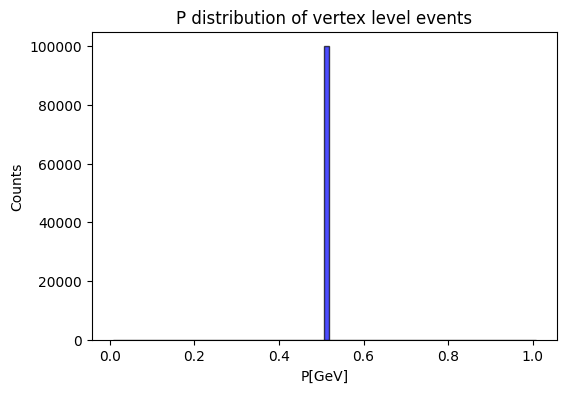

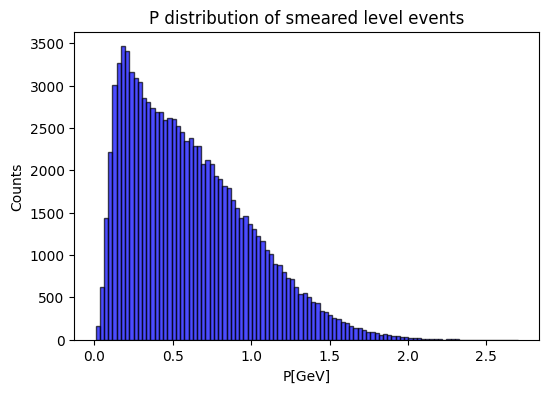

In [8]:
# Create 1D histograms for each component of the 4-momentum vector (identical_events)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot a histogram for one component, say 'p0' (since all are identical)
ax.hist(P_vertex, bins=100, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
ax.set_title("P distribution of vertex level events")
ax.set_xlabel("P[GeV]")
ax.set_ylabel("Counts")

# Show the plot
plt.show()
##############################

# Create 1D histograms for each component of the 4-momentum vector (identical_events)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot a histogram for one component, say 'p0' (since all are identical)
ax.hist(P_smeared, bins=100, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
ax.set_title("P distribution of smeared level events")
ax.set_xlabel("P[GeV]")
ax.set_ylabel("Counts")

# Show the plot
plt.show()

### Training dataset loading + some checks and plots

In [9]:
training_events=smeared_events

## HANDS ON 2: GAN model implementation

We are now ready to build our network! The tasks we will need to go through are the following:

* Build the model architectures
* Chose the appropriate loss function for each model
* Define a training loop
* Identify a way to look at how the training is going


In the following cell we go through these different steps leaving the construction of the discriminator as an exercise:
1. Can you come up with a good enough architecture for the Discriminator in order for the model to compile and train?

    Hints:
  * Can I use the Generator as a template to build the Discriminator? What are the similarities? What are the differences? 
  * How can I check that everything is going in the right direction during the training?
 
2. What happens to the training if I increase or reduce the **learning rate** of the different models?

    * Keeping the two learning rates (Generator and Discriminator) the same, for semplicity, what happens to the training if I make the learning rate too small or too big?
    * Can you interpret what is happening to the model in the different cases?

In [1]:
l_r =  0.0001

class GAN():
    def __init__(self):
        self.latent_dim = 100

        # Build the Discriminator
        self.discriminator = self.build_discriminator()
        
        self.discriminator.compile(loss='mse',optimizer=Adam(learning_rate=l_r, beta_1=0.5), metrics=['accuracy'])

        # Build the Generator
        self.generator = self.build_generator()

        generator_noise = Input(shape=(self.latent_dim,))   # Generator input noise
        generator_vertex = Input(shape=(V_dataset.shape[1],))  # Generator input vertex level events
        Det_events = self.generator([generator_vertex, generator_noise]) # Generator 

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated detector_events as input and determines validity
        valid = self.discriminator(Det_events)
       
        # The combined model  (Generator + Discriminator)---> Trains generator to fool discriminator
        self.combined = Model([generator_vertex, generator_noise], valid )
        self.combined.compile(loss='mse', optimizer=Adam(learning_rate=l_r, beta_1=0.5))    

    
    def build_generator(self):
        v = Input(shape=(V_dataset.shape[1],)) 
        noise = Input(shape=(100,))
        x = Concatenate()([v, noise])
        
        x= Dense(64)(x)
        x=LeakyReLU(alpha=0.2)(x)
        #x = BatchNormalization(momentum=0.8)(x)
        
        x= Dense(128)(x)
        x=LeakyReLU(alpha=0.2)(x)
        #x = BatchNormalization(momentum=0.8)(x)
        
        x= Dense(256)(x)
        x=LeakyReLU(alpha=0.2)(x)
        #x = BatchNormalization(momentum=0.8)(x)
        
        output = Dense(4)(x)
        outputmerge = concatenate([v, output])
        
        generator = Model(inputs=[v,noise], outputs=outputmerge)
        generator.summary()
        return(generator)

    def build_discriminator(self):
        D = Input(shape=(8,))
        x = Dense(256)(D)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(128)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dense(64)(x)
        x = LeakyReLU(alpha=0.2)(x)
        output = Dense(1)(x)
        discriminator = Model(inputs=D, outputs=output)
        discriminator.summary()
        return discriminator

    def train(self, epochs, batch_size=128, sample_interval=50): 
        # training loop for the full model

        training_dataset = tf.data.Dataset.from_tensor_slices(training_events)#.astype(np.float32))
        training_dataset = training_dataset.shuffle(buffer_size=1024).batch(batch_size)

        dloss=[]
        gloss=[]
        for epoch in range(epochs):
            for step, X_train in enumerate(training_dataset):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                idx = tf.random.uniform(shape=(batch_size,), minval=0, maxval=tf.shape(X_train)[0], dtype=tf.int32)
                
                # Select data using the same indices
                imgs = tf.gather(X_train, idx)  # Select real detector-level events
                labels = tf.gather(V_dataset, idx) #Real vertex level events
                
                true_perturbation = tf.random.normal([tf.shape(imgs)[0], tf.shape(imgs)[1] * 2], mean=0.0, stddev=0.1)
                true_input = tf.concat([labels, imgs], axis = 1) 

                
                gen_noise_input = tf.random.normal(shape=(batch_size, self.latent_dim), mean=0.0, stddev=1.0, dtype=tf.float32)
                gen_output = self.generator.predict([labels, gen_noise_input], verbose = 0)

                gen_perturbation = tf.random.normal([tf.shape(imgs)[0], tf.shape(imgs)[1] * 2], mean=0.0, stddev=0.1)
                
                gen_detect_evts = gen_output + gen_perturbation
                
                
                d_loss_real = self.discriminator.train_on_batch(true_input, tf.ones((X_train.shape[0],)))
                d_loss_fake = self.discriminator.train_on_batch(gen_detect_evts, tf.zeros((X_train.shape[0],)))
                d_loss = (d_loss_real[0] + d_loss_fake[0])
                d_accuracy = (d_loss_real[1] + d_loss_fake[1])
                

                # ---------------------
                #  Train the Generator
                # ---------------------
    
                g_loss = self.combined.train_on_batch([labels, gen_noise_input], tf.ones((X_train.shape[0],)))
    
                dloss.append(d_loss)
                gloss.append(g_loss)
            if epoch % sample_interval == 0:
                print ("epoch: %d ,step: %d [D loss: %f] [G loss: %f]" % (epoch, step, d_loss, g_loss))
                #self.sample_images(epoch, dloss, gloss)
                self.sample_images(step, dloss, gloss)
                    
                    
                self.generator.save_weights('./G_%d.h5'%(epoch+EP))
                self.discriminator.save_weights('./D_%d.h5'%(epoch+EP))
                print('saved ...')

    def sample_images(self, epoch, dloss, gloss):  
        
        t = time.time()
        time_elapsed = t - t0
        print("time elapsed: %.2f"%(time_elapsed/60.))
#################################################
        
        SAMPLE_SIZE = 10000
        noise = tf.random.normal(shape=(SAMPLE_SIZE, self.latent_dim), mean=0.0, stddev=1.0, dtype=tf.float32)

        
        # Generate samples using the generator
        results = self.generator.predict([V_dataset[:SAMPLE_SIZE, :], noise], SAMPLE_SIZE)
        
        # Extract the 4-momenta components from generated samples
        generated_E = results[:, 4]
        generated_Px = results[:, 5]
        generated_Py = results[:, 6]
        generated_Pz = results[:, 7]
        
        G_P = np.sqrt(generated_Px*generated_Px + generated_Py*generated_Py + generated_Pz*generated_Pz)

        idx = tf.random.uniform(shape=(SAMPLE_SIZE,), minval=0, maxval=tf.shape(training_events)[0], dtype=tf.int32)
        real_samples = tf.gather(training_events, idx)
        real_E = real_samples[:, 0]
        real_Px = real_samples[:, 1]
        real_Py = real_samples[:, 2]
        real_Pz = real_samples[:, 3]

        R_P = np.sqrt(real_Px*real_Px + real_Py*real_Py + real_Pz*real_Pz)
        
                        # Plot histograms for P
        plt.figure(figsize=(10, 5))
        plt.hist(R_P, bins=50, alpha=0.5, label='Real P')
        plt.hist(G_P, bins=50, alpha=0.5, label='Generated P')
        plt.title('P Distribution')
        plt.legend()
        plt.show()


        ## histograms for training variables
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))
        # Plot histogram for E
        axs[0, 0].hist(real_E, bins=50, alpha=0.5, label='Real E')
        axs[0, 0].hist(generated_E, bins=50, alpha=0.5, label='Generated E')
        axs[0, 0].set_title('E Distribution')
        axs[0, 0].legend()

        # Plot histogram for Px
        axs[0, 1].hist(real_Px, bins=50, alpha=0.5, label='Real Px')
        axs[0, 1].hist(generated_Px, bins=50, alpha=0.5, label='Generated Px')
        axs[0, 1].set_title('Px Distribution')
        axs[0, 1].legend()

        # Plot histogram for Py
        axs[1, 0].hist(real_Py, bins=50, alpha=0.5, label='Real Py')
        axs[1, 0].hist(generated_Py, bins=50, alpha=0.5, label='Generated Py')
        axs[1, 0].set_title('Py Distribution')
        axs[1, 0].legend()

        # Plot histogram for Pz
        axs[1, 1].hist(real_Pz, bins=50, alpha=0.5, label='Real Pz')
        axs[1, 1].hist(generated_Pz, bins=50, alpha=0.5, label='Generated Pz')
        axs[1, 1].set_title('Pz Distribution')
        axs[1, 1].legend()

        plt.tight_layout()
        plt.show()        
        
        ############################################
        nrows,ncols=1,1
        fig = pyy.figure(figsize=(ncols*7,nrows*5))

        ax=pyy.subplot(nrows,ncols,1)
        ax.plot(range(1,len(gloss)+1),gloss,label=r'$\rm generator$')
        ax.plot(range(1,len(dloss)+1),dloss,label=r'$\rm discriminator$')
        ax.semilogy()
        ax.semilogx()
        ax.legend(fontsize=20)
        ax.set_ylabel(r'$\rm Loss$',size=20)
        ax.set_xlabel(r'$\rm epochs$',size=20)
        ax.tick_params(axis='both', which='both', labelsize=15,direction='in')
        plt.show()

## HANDS ON 2: ANSWER

In [19]:


## sc2 = BatchNormalization(momentum=0.8)(sc22)
## x=Dropout(dropout)(x)


#l_r too small: I'm stuck in a local minimum! I can't converge to the right value
#L_r too big: I don

In [2]:
t0 = time.time()
gan = GAN()

NameError: name 'time' is not defined

epoch: 0 ,step: 19 [D loss: 0.747409] [G loss: 0.513537]
time elapsed: 0.15
1/1 [==============================] - 0s 21ms/step


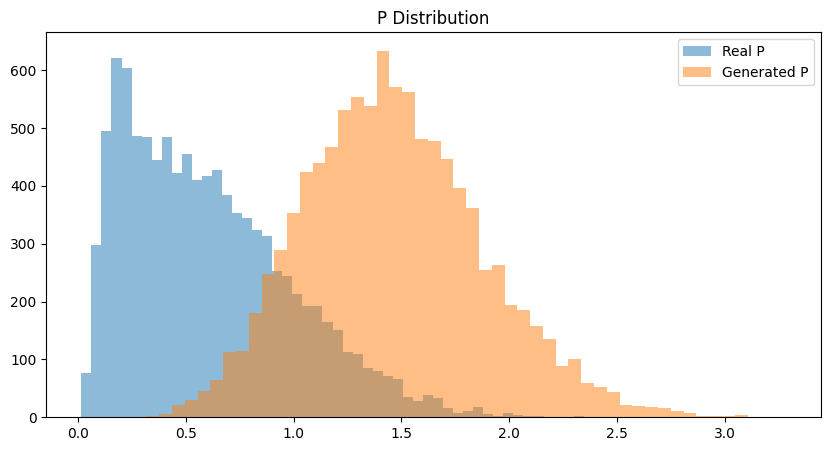

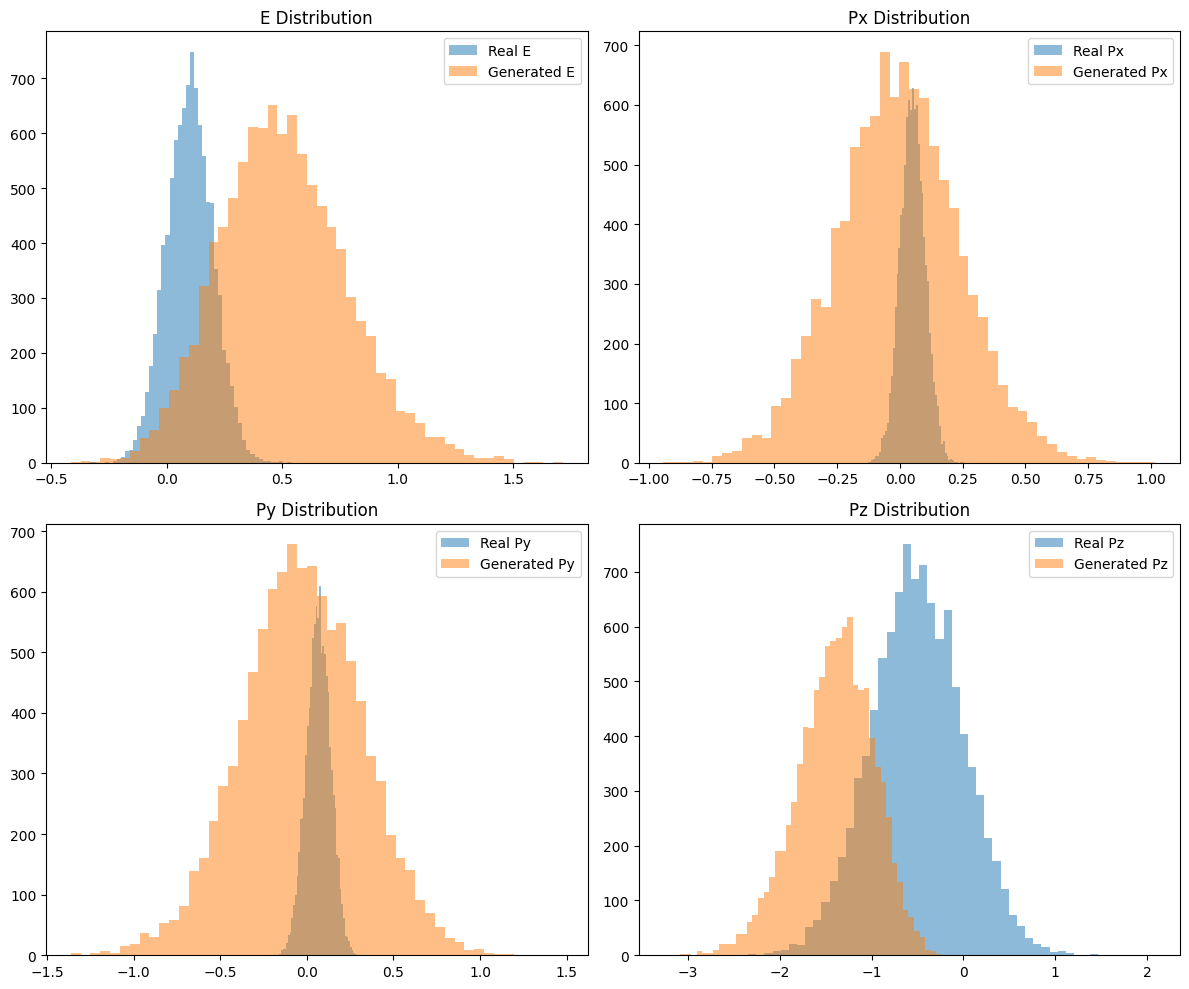

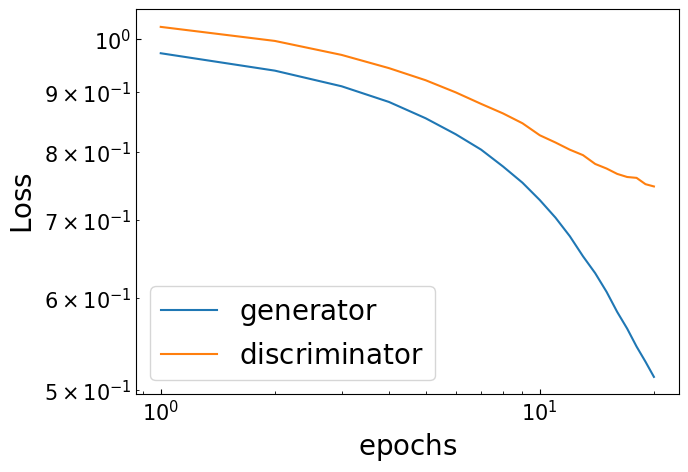

saved ...
epoch: 10 ,step: 19 [D loss: 0.458865] [G loss: 0.239903]
time elapsed: 1.59
1/1 [==============================] - 0s 22ms/step


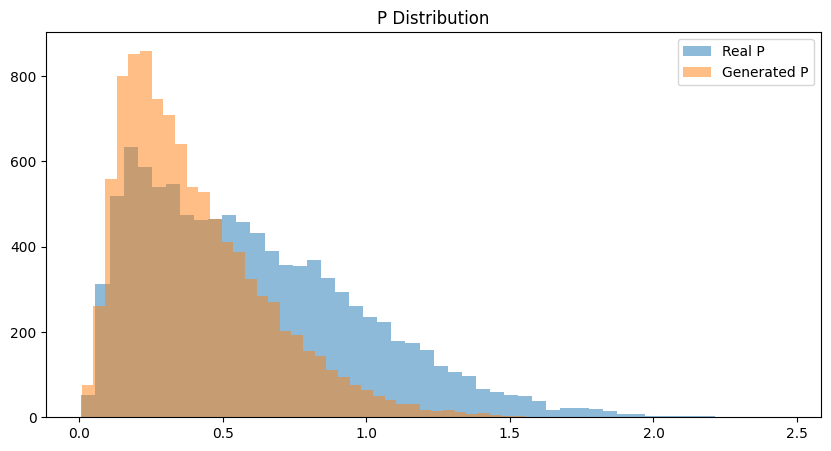

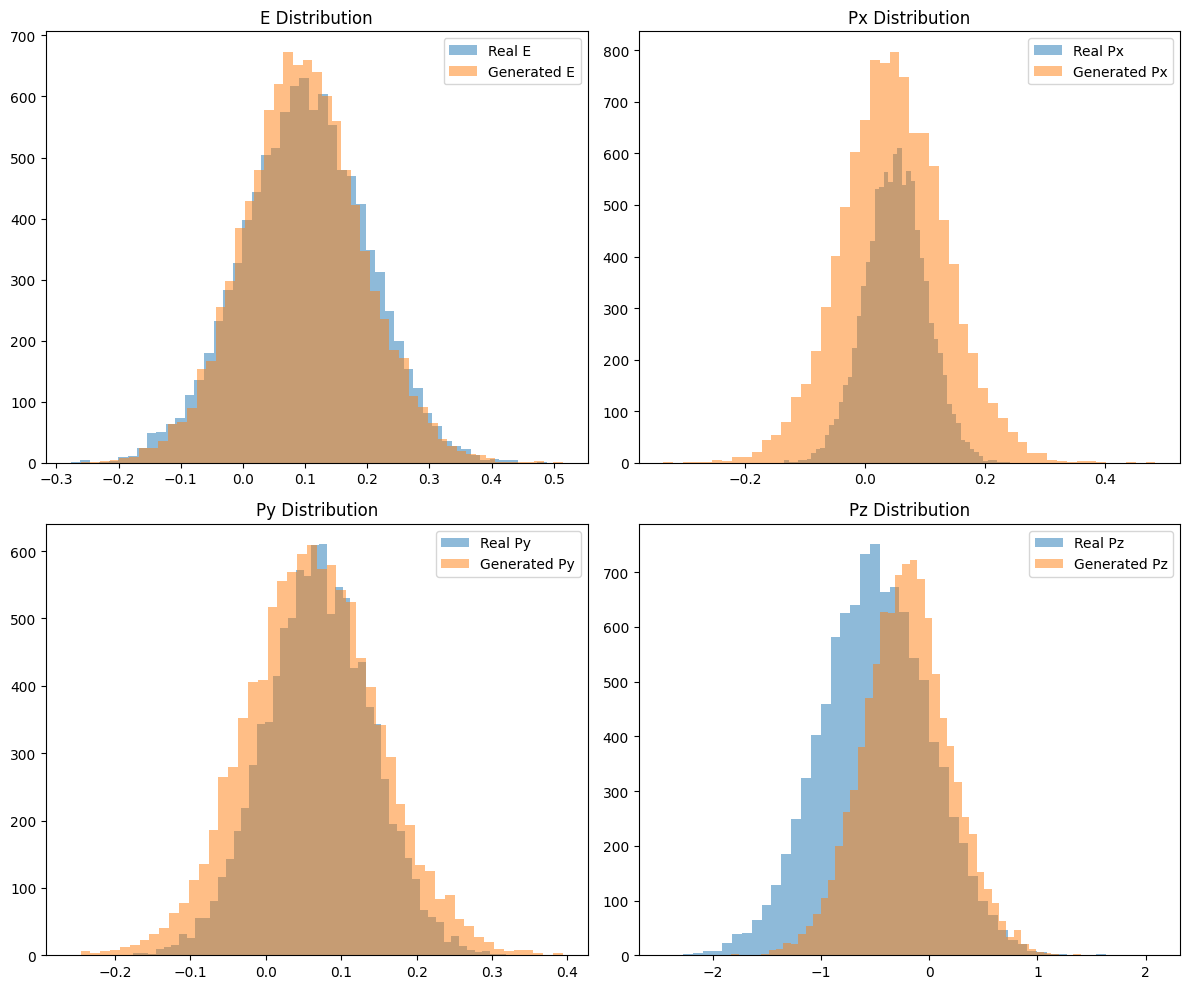

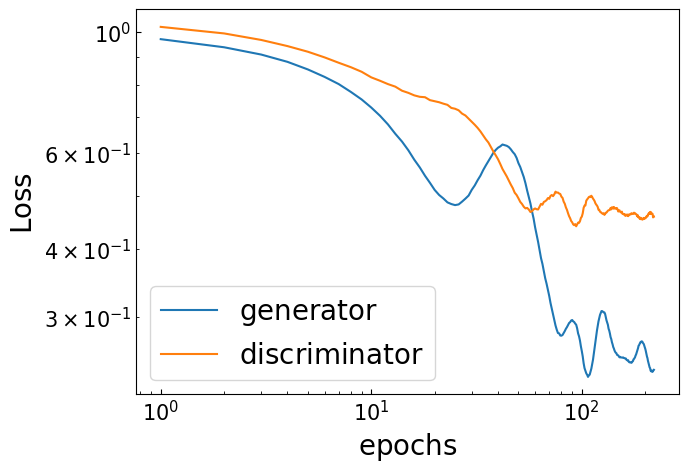

saved ...
epoch: 20 ,step: 19 [D loss: 0.423555] [G loss: 0.194488]
time elapsed: 3.09
1/1 [==============================] - 0s 20ms/step


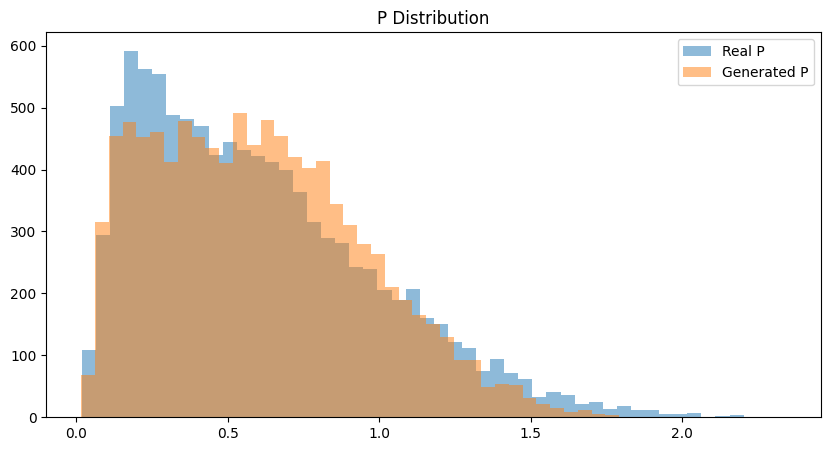

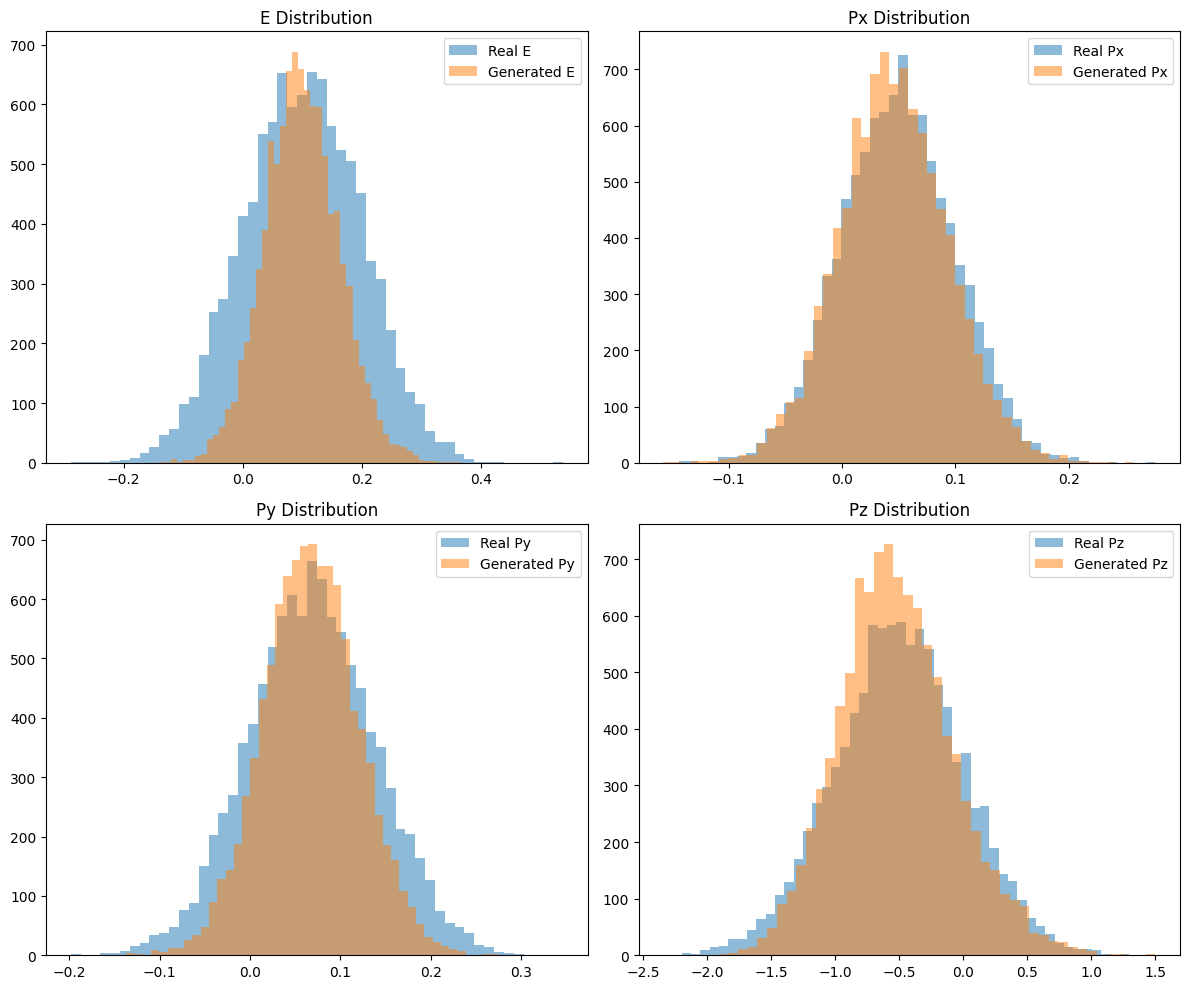

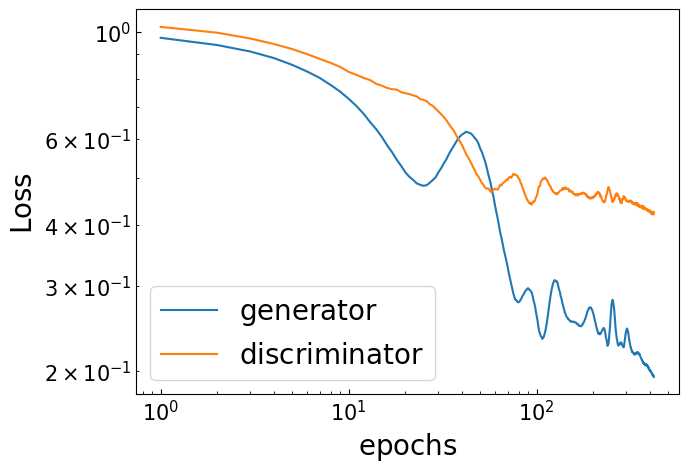

saved ...
epoch: 30 ,step: 19 [D loss: 0.338544] [G loss: 0.118697]
time elapsed: 4.61
1/1 [==============================] - 0s 20ms/step


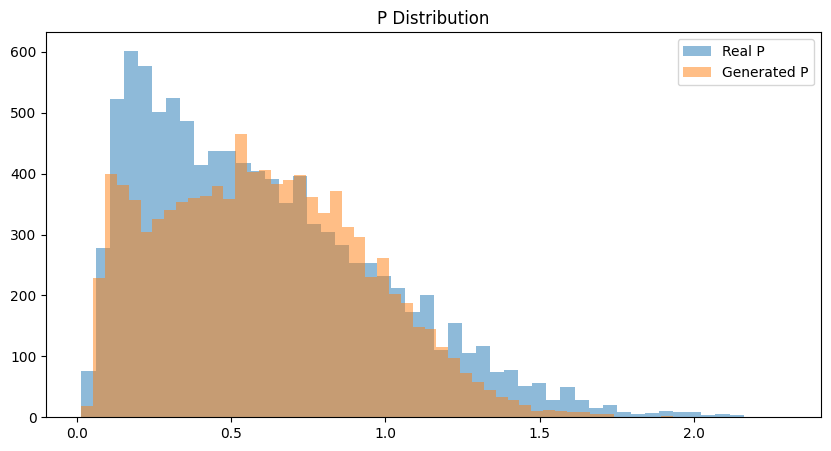

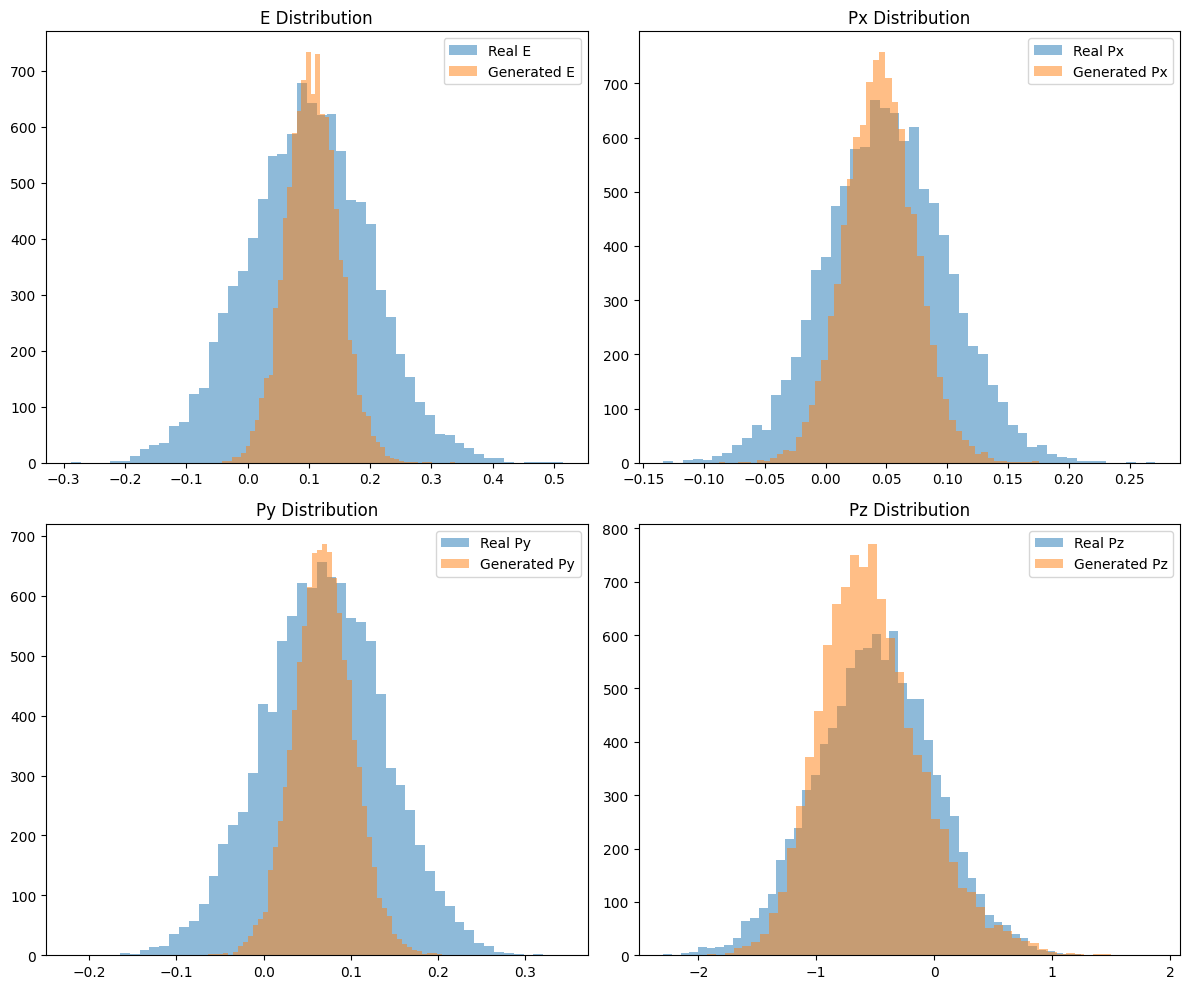

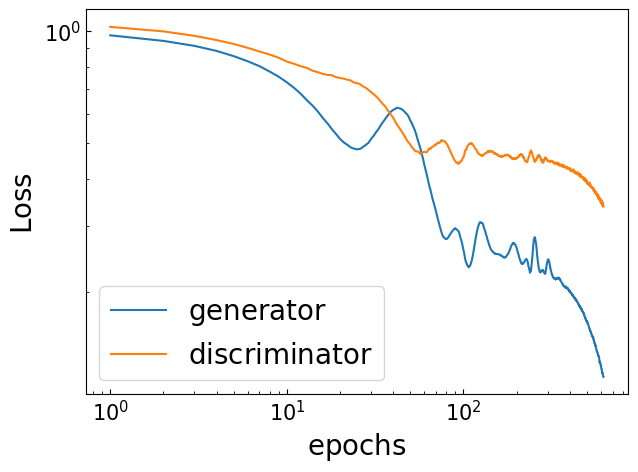

saved ...
epoch: 40 ,step: 19 [D loss: 0.242951] [G loss: 0.040773]
time elapsed: 6.09
1/1 [==============================] - 0s 20ms/step


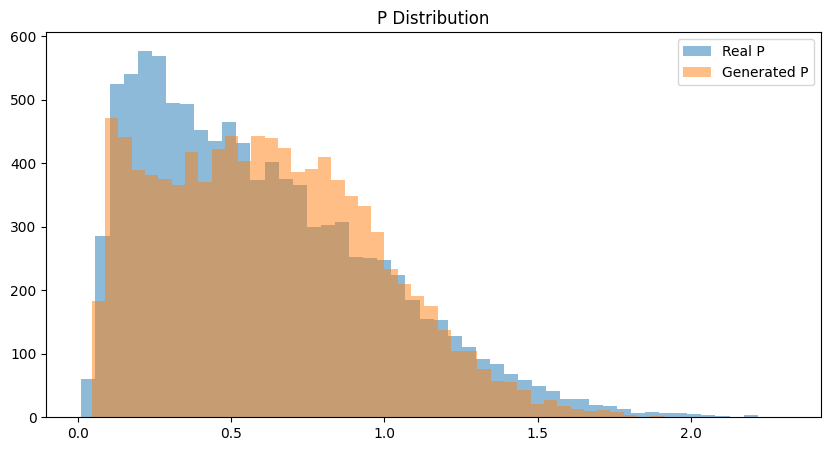

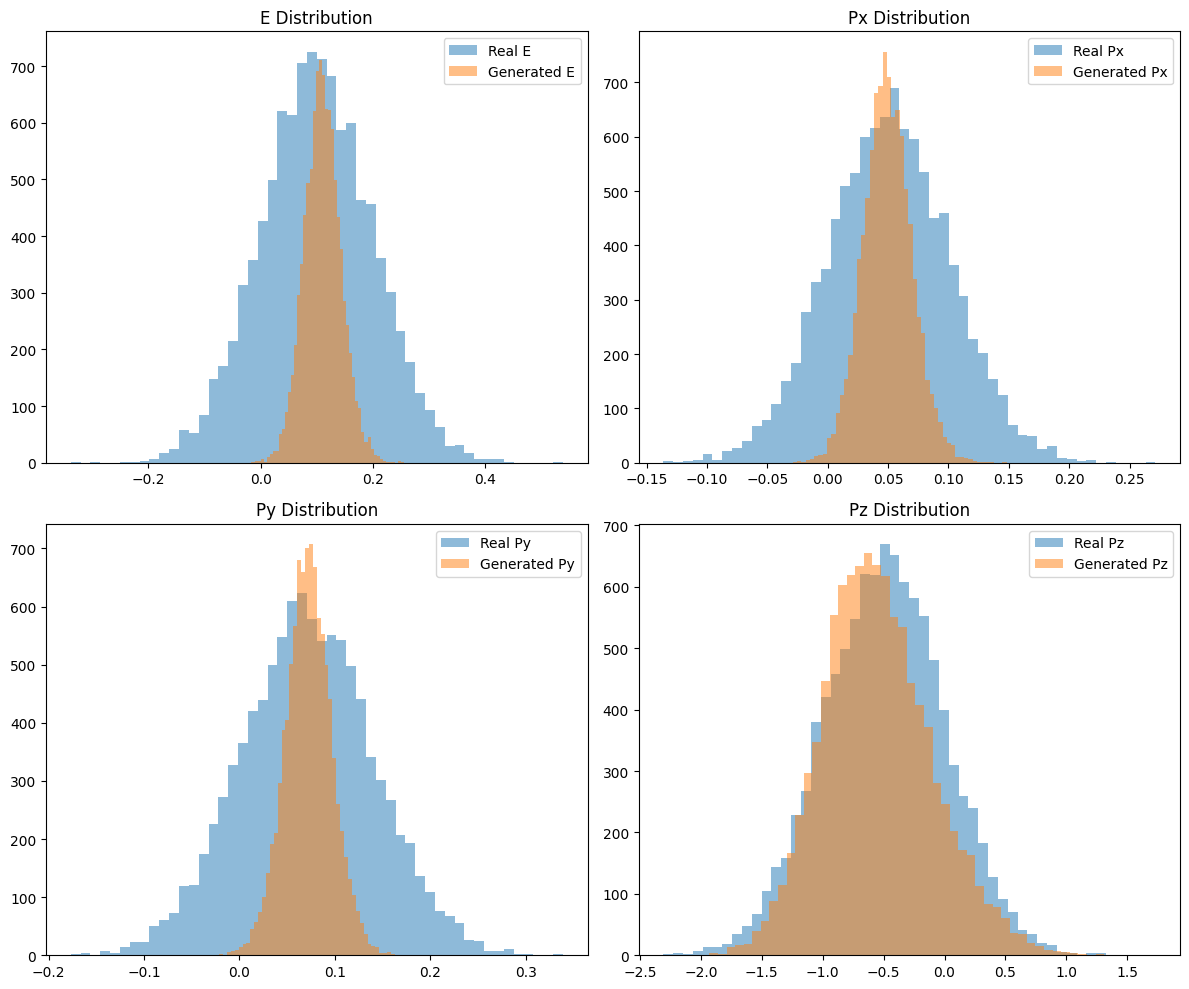

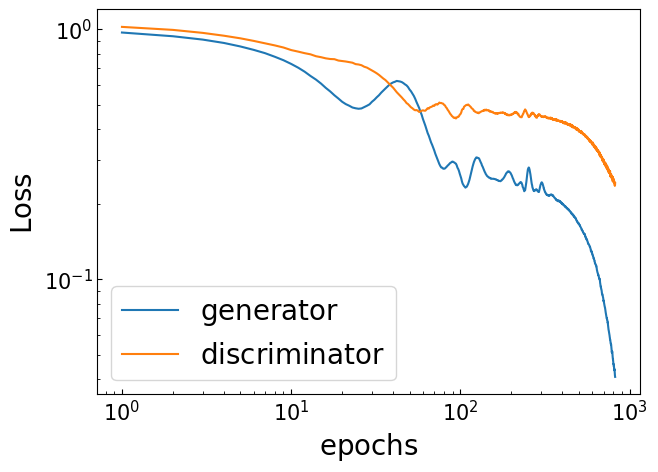

saved ...
epoch: 50 ,step: 19 [D loss: 0.180788] [G loss: 0.009363]
time elapsed: 7.48
1/1 [==============================] - 0s 22ms/step


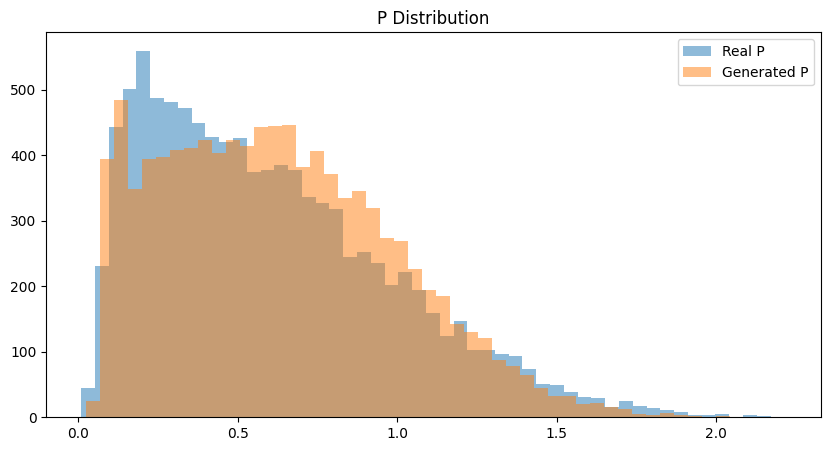

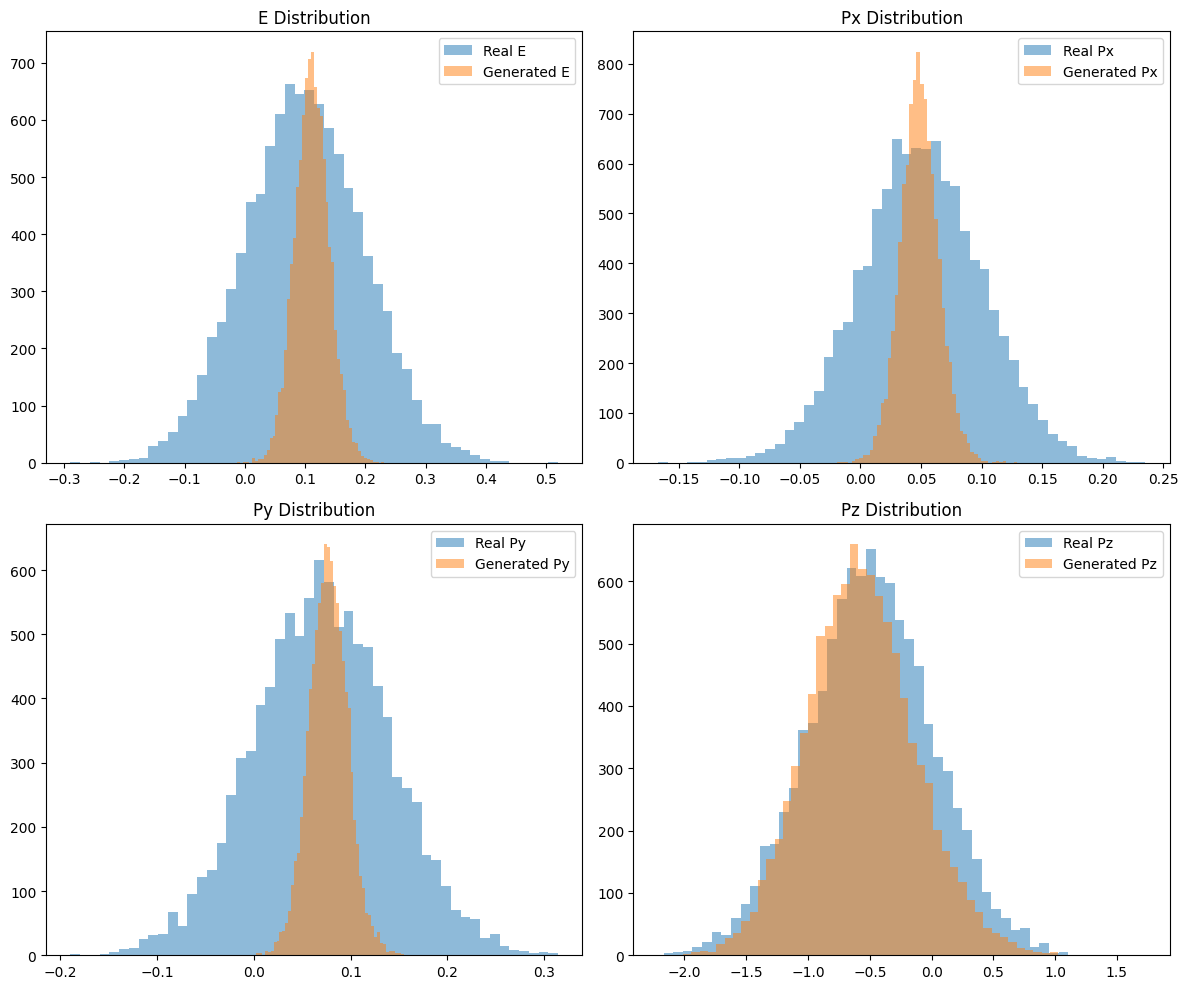

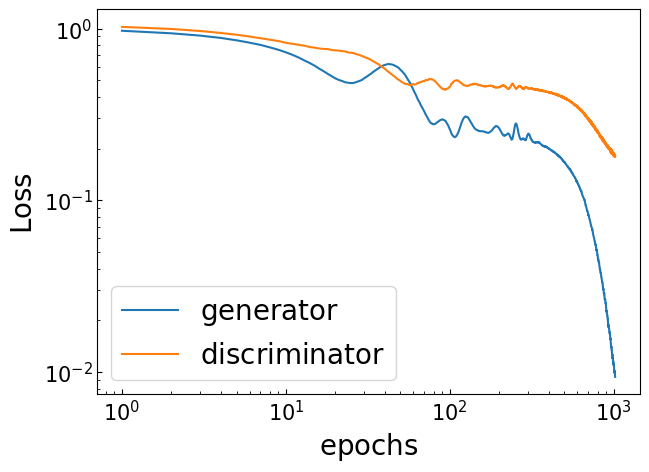

saved ...
epoch: 60 ,step: 19 [D loss: 0.153970] [G loss: 0.003297]
time elapsed: 8.90
1/1 [==============================] - 0s 19ms/step


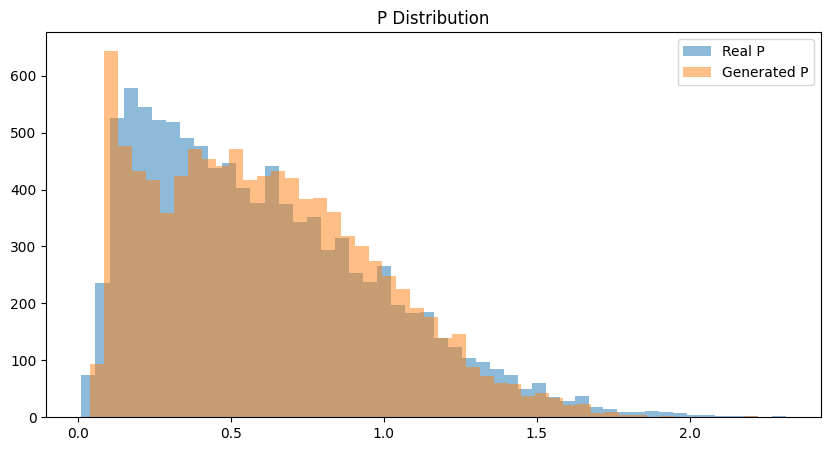

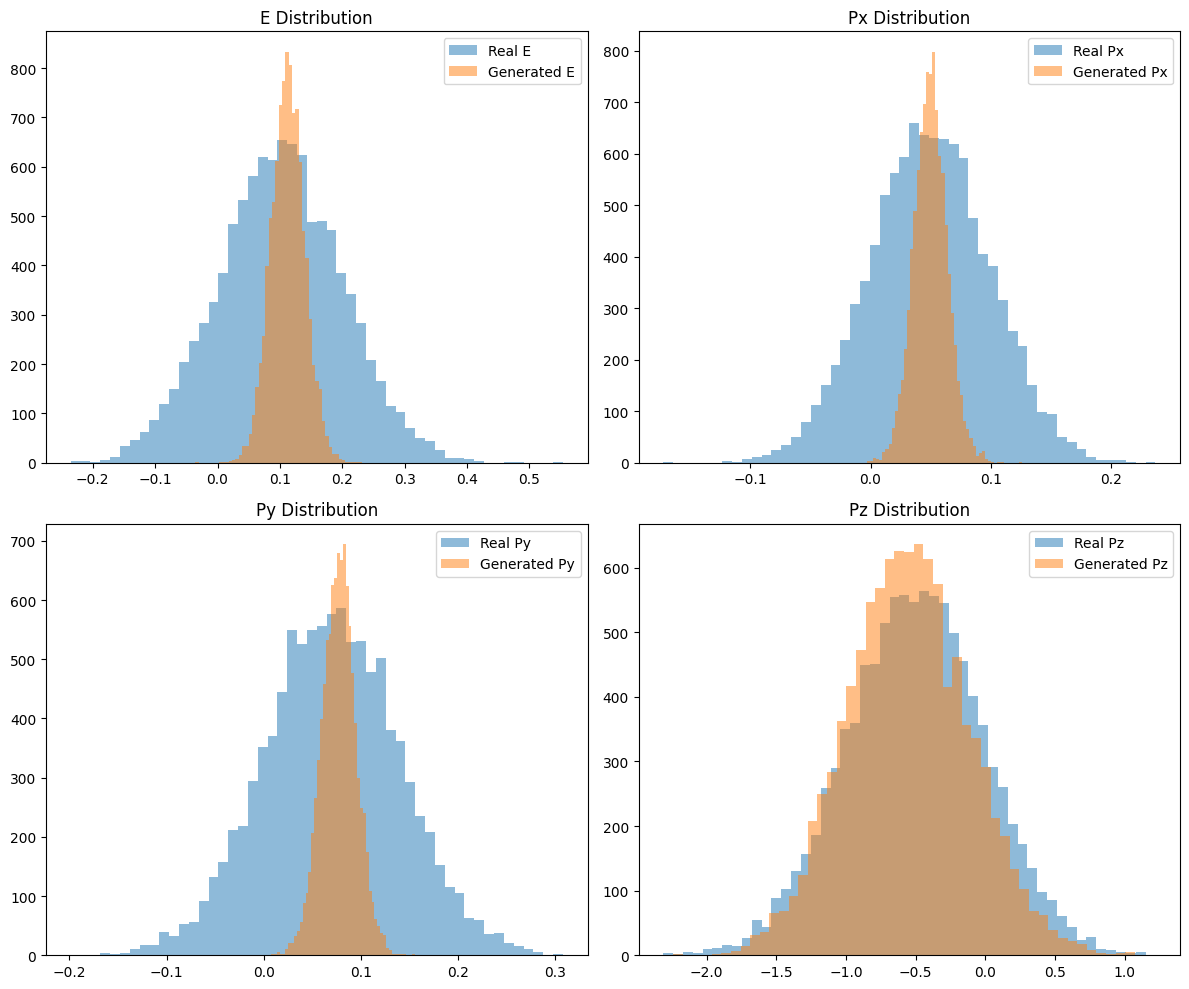

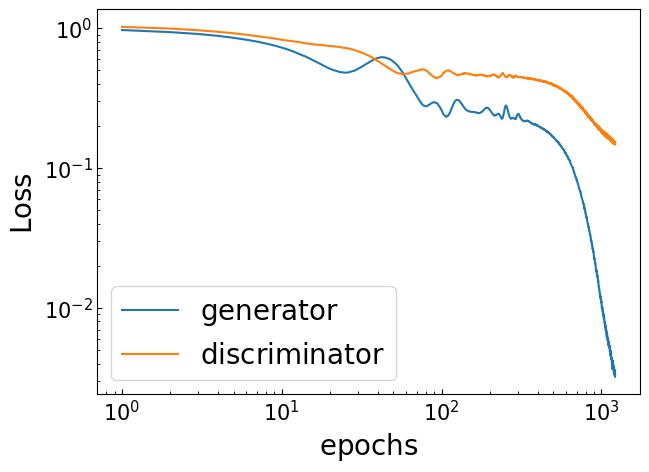

saved ...


KeyboardInterrupt: 

In [24]:
t0 = time.time()
EP = 0

#gan.generator.load_weights('/home/private/Gauss_smearing/G_%d.h5'%(EP))
#gan.discriminator.load_weights('/home/private/Gauss_smearing/D_%d.h5'%(EP))

gan.train(epochs=101, batch_size=5000, sample_interval=10)

## HANDS ON 3: Uncertainty quantification: Pull plots

Now that we have trained our model and got a good agreement between training and generated data, we are satisfied and can move on... or can we?

Looking at our histograms we could say that the different distributions match pretty well, our model seems like has reached a satisfactory dynamical equilibrium, but we're still missing something.

The goal of this procedure is to guarantee that the highly non trivial multi-dimentional correlation between our variables that we'd like to capture with our model are well preserved in a **local** way.

So far we have done the following:

* Just looking at the loss function, the agreement we obtained is **global**, in the sense that we only know if the full distribution we generated is similar to the training dataset.

* Have a qualitative comparison between the two sets of histogram.

To have a quantitative estimate we introduce the pull plot metrics as follows:

$$pull = \frac{\mu_R + \mu_G}{\sqrt{\sigma^2_R+\sigma^2_G}}$$

Where:
- $\mu_R$: Is the number "real" training data in a given bin.
- $\mu_G$: Is the number "fake" generated data in a given bin.
- $\sigma_R$: Is the statistical error associated to the "real" data in a given bin.
- $\sigma_G$: Is the statistical error associated to the "fake" data in a given bin.

In [28]:
def pulls(real_data, generated_data, bins=50):
    # quantifies the error between real and generated data
    
    hist_real, edges_real = np.histogram(real_data, bins=bins)
    hist_generated, edges_generated = np.histogram(generated_data, bins=bins)
    bin_centers = 0.5 * (edges_real[1:] + edges_real[:-1])

    err_real = np.sqrt(hist_real)
    err_generated = np.sqrt(hist_generated)

    epsilon = 1e-7
    pulls = np.where((hist_real != 0) | (hist_generated != 0),
                     (hist_real - hist_generated) / np.sqrt(hist_real + hist_generated + epsilon),
                             0.0)

    return bin_centers, hist_real, hist_generated, err_real, err_generated, pulls

Can you utilize this function to compare true and generated samples?

1. load the best weights for your model
2. Generate new data as the output of your pre-trained generator
3. Select a subset of the training data of the same size
4. Calculate pulls
5. plot the results


In [ ]:
### 

## HANDS ON 3: Uncertainty quantification: Answers

1/1 [==============================] - 0s 24ms/step
(10000, 8) (10000, 4)


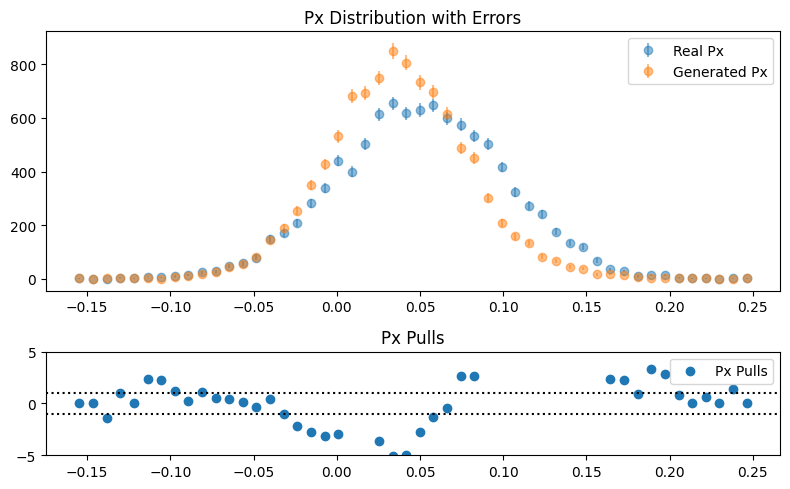

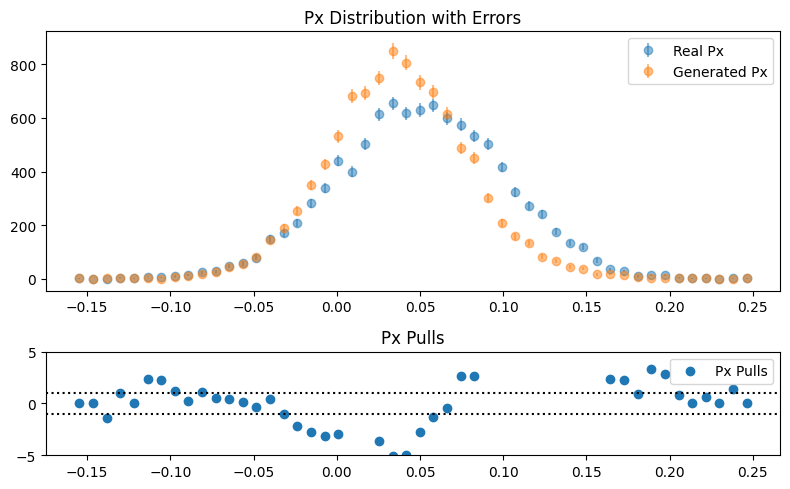

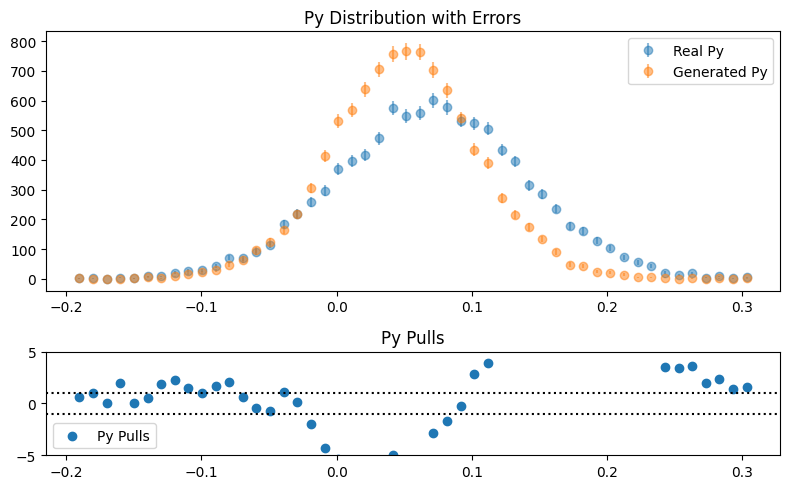

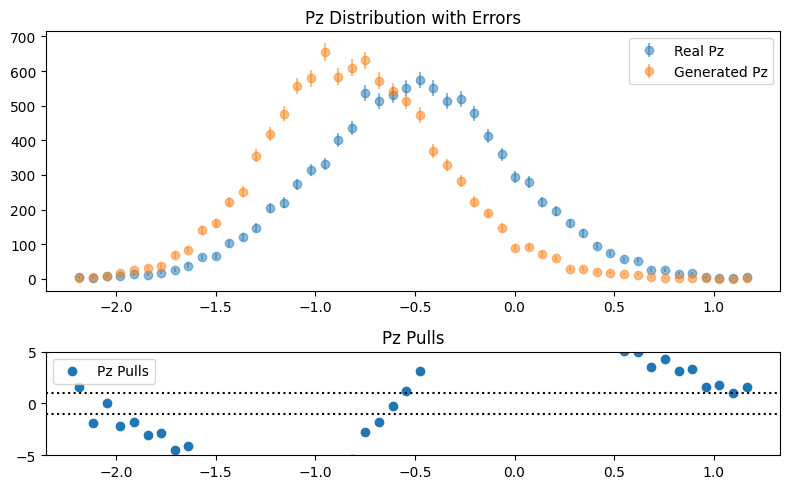

In [29]:
EP = 50

gan.generator.load_weights('G_%d.h5'%(EP))
gan.discriminator.load_weights('D_%d.h5'%(EP))

SAMPLE_SIZE = 10000
noise = tf.random.normal(shape=(SAMPLE_SIZE, 100), mean=0.0, stddev=1.0, dtype=tf.float32)

# Generate samples using the generator
results = gan.generator.predict([V_dataset[:SAMPLE_SIZE, :], noise], SAMPLE_SIZE)

# Extract the 4-momenta components from generated samples
generated_E = results[:, 4]
generated_Px = results[:, 5]
generated_Py = results[:, 6]
generated_Pz = results[:, 7]

G_P = np.sqrt(generated_Px*generated_Px + generated_Py*generated_Py + generated_Pz*generated_Pz)
idx = tf.random.uniform(shape=(SAMPLE_SIZE,), minval=0, maxval=tf.shape(training_events)[0], dtype=tf.int32)
real_samples = tf.gather(training_events, idx)
real_E = real_samples[:, 0]
real_Px = real_samples[:, 1]
real_Py = real_samples[:, 2]
real_Pz = real_samples[:, 3]
R_P = np.sqrt(real_Px*real_Px + real_Py*real_Py + real_Pz*real_Pz)


print(results.shape, real_samples.shape)


bin_centers_E, hist_real_E, hist_generated_E, err_real_E, err_generated_E, pulls_E = pulls(real_E, generated_E)
bin_centers_Px, hist_real_Px, hist_generated_Px, err_real_Px, err_generated_Px, pulls_Px = pulls(real_Px, generated_Px)
bin_centers_Py, hist_real_Py, hist_generated_Py, err_real_Py, err_generated_Py, pulls_Py = pulls(real_Py, generated_Py)
bin_centers_Pz, hist_real_Pz, hist_generated_Pz, err_real_Pz, err_generated_Pz, pulls_Pz = pulls(real_Pz, generated_Pz)


        ############ Plot errors for E
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

# Top plot for Px distribution with errors
axs[0].errorbar(bin_centers_Px, hist_real_Px, yerr=err_real_Px, fmt='o', label='Real Px', alpha=0.5)
axs[0].errorbar(bin_centers_Px, hist_generated_Px, yerr=err_generated_Px, fmt='o', label='Generated Px', alpha=0.5)
axs[0].set_title('Px Distribution with Errors')
axs[0].legend()

        # Bottom plot for Px pulls
axs[1].scatter(bin_centers_Px, pulls_Px, label='Px Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Px Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()

        ########### Plot errors for Px
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Px
axs[0].errorbar(bin_centers_Px, hist_real_Px, yerr=err_real_Px, fmt='o', label='Real Px', alpha=0.5)
axs[0].errorbar(bin_centers_Px, hist_generated_Px, yerr=err_generated_Px, fmt='o', label='Generated Px', alpha=0.5)
axs[0].set_title('Px Distribution with Errors')
axs[0].legend()

        # Plot pulls for Px
axs[1].scatter(bin_centers_Px, pulls_Px, label='Px Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Px Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()

        ########### Plot errors for Py
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Py
axs[0].errorbar(bin_centers_Py, hist_real_Py, yerr=err_real_Py, fmt='o', label='Real Py', alpha=0.5)
axs[0].errorbar(bin_centers_Py, hist_generated_Py, yerr=err_generated_Py, fmt='o', label='Generated Py', alpha=0.5)
axs[0].set_title('Py Distribution with Errors')
axs[0].legend()

        # Plot pulls for Py
axs[1].scatter(bin_centers_Py, pulls_Py, label='Py Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Py Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()

        ########### Plot errors for Pz
fig, axs = plt.subplots(2, 1, figsize=(8, 5), gridspec_kw={'height_ratios': [5, 2]})

        # Top plot for Pz
axs[0].errorbar(bin_centers_Pz, hist_real_Pz, yerr=err_real_Pz, fmt='o', label='Real Pz', alpha=0.5)
axs[0].errorbar(bin_centers_Pz, hist_generated_Pz, yerr=err_generated_Pz, fmt='o', label='Generated Pz', alpha=0.5)
axs[0].set_title('Pz Distribution with Errors')
axs[0].legend()

        # Plot pulls for Pz
axs[1].scatter(bin_centers_Pz, pulls_Pz, label='Pz Pulls')
axs[1].axhline(1, ls=':', color='k')
axs[1].axhline(-1, ls=':', color='k')
axs[1].set_ylim(-5, 5)
axs[1].set_title('Pz Pulls')
axs[1].legend()

plt.tight_layout()
plt.show()